In [33]:
#importando as dependencias necessarias
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr
import itertools

In [ ]:
#formatando o arquivo de logger para ser compativel com o pandas
#obs: o arquivo de logger sera sobreescrito (podendo nao ser necesssario executar essa celula para determinado arquivo)
with open('data/loggerECG.json', 'r+') as file:
    dic = file.read()
    f = json.loads(dic)
    for key in f:
        f[key] = list(f[key][0][1:-1].split(', '))

    for key in f:
        d = {}
        for i in range(len(f[key])):
            d[i] = f[key][i]
        f[key] = d
    file.seek(0)
    file.write(json.dumps(f))
    file.truncate()

In [4]:
#definicao de variaveis
items = ['battery', 'size', 'pressure', 'lux', 'heartbeat',
         'ecg', 'ppg', 'saturation', 'accelerometerZ', 'accelerometerX',
         'accelerometerY', 'gyroscopeZ', 'gyroscopeX', 'gyroscopeY']
units = {'battery': 'bateria (%)',
             'size': 'armazenamento (MB)',
             'pressure': 'pressao (hPa)',
             'lux': 'luminosidade (lux)',
             'heartbeat': 'taxa de batimentos (bpm)',
             'ecg': 'ecg cru (mV)',
             'ppg': 'ppg cru (mV)',
             'saturation': 'oxigenacao crua (mV)',
             'accelerometerZ': 'aceleracao (m/s²)',
             'accelerometerX': 'aceleracao (m/s²)',
             'accelerometerY': 'aceleracao (m/s²)',
             'gyroscopeZ': 'giroscopio (rad/s)',
             'gyroscopeX': 'giroscopio (rad/s)',
             'gyroscopeY': 'giroscopio (rad/s)'}

In [5]:
#removendo o id do smartwatch do dataframe
df = pd.read_json('data/loggerECG.json')
df.drop(['ID_Smartwatch'], axis=1, inplace=True)
#print(df)

In [6]:
#visao geral dos dados (quantidade, media, desvio padrao, minimo, q1, mediana, q3 e maximo)
#df.head()
df.describe()

,battery,size,pressure,lux,heartbeat,ecg,ppg,saturation,accelerometerZ,accelerometerX,accelerometerY,gyroscopeZ,gyroscopeX,gyroscopeY
count,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7.999000e+03,7999.0,7999.0,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000
mean,54.385548,0.643945,1007.855995,1.214652,68.066883,-4.899664e+05,0.0,0.0,0.131138,-2.693601,-0.621971,0.001596,0.011676,-0.000853
std,24.142180,0.370962,0.836306,3.714600,15.464021,1.364243e+05,0.0,0.0,3.663036,4.624406,7.472779,0.649539,0.329696,0.404720
min,9.000000,0.000000,1006.034900,0.000000,0.000000,-2.535798e+06,0.0,0.0,-15.655684,-27.126305,-15.174450,-13.927728,-3.120300,-4.902804
25%,35.000000,0.322403,1007.099240,0.000000,57.000000,-5.963120e+05,0.0,0.0,-3.423708,-6.142325,-9.481039,-0.025656,-0.012217,-0.010996
50%,54.000000,0.644951,1008.024400,0.000000,64.000000,-4.699840e+05,0.0,0.0,1.290475,-3.277662,0.040701,0.000000,0.000000,0.000000
75%,73.000000,0.965863,1008.540170,0.000000,78.000000,-3.756855e+05,0.0,0.0,2.513912,1.189918,6.900089,0.023213,0.010996,0.010996
max,98.000000,1.282929,1009.174300,36.000000,108.000000,2.176730e+05,0.0,0.0,17.223886,12.284649,25.713726,7.562512,5.137377,6.519154


In [7]:
#checando a existencia de valores nulos/faltantes
#df.isna().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7999 entries, 0 to 7998
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype                                
---  ------          --------------  -----                                
 0   datetime        7999 non-null   datetime64[ns, pytz.FixedOffset(180)]
 1   battery         7999 non-null   int64                                
 2   size            7999 non-null   float64                              
 3   pressure        7999 non-null   float64                              
 4   lux             7999 non-null   int64                                
 5   heartbeat       7999 non-null   int64                                
 6   ecg             7999 non-null   int64                                
 7   ppg             7999 non-null   int64                                
 8   saturation      7999 non-null   int64                                
 9   accelerometerZ  7999 non-null   float64                        

In [8]:
#substituindo os valores faltantes pela media da coluna (caso nao existam nao e necessario executar essa celula)
#obs: apenas valido para valores numericos
num_col = [] # lista com as colunas que possuem valores faltantes
for col in num_col:
    df[col]=pd.to_numeric(df[col])
    df[col].fillna(df[col].mean(), inplace=True)
df.isna().sum()

datetime          0
battery           0
size              0
pressure          0
lux               0
heartbeat         0
ecg               0
ppg               0
saturation        0
accelerometerZ    0
accelerometerX    0
accelerometerY    0
gyroscopeZ        0
gyroscopeX        0
gyroscopeY        0
dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x2aeaa29a8e0>,
 'caps': [<matplotlib.lines.Line2D at 0x2aeaa29ae80>,
 'boxes': [<matplotlib.lines.Line2D at 0x2aeaa29a610>],
 'medians': [<matplotlib.lines.Line2D at 0x2aeaa288460>],
 'fliers': [<matplotlib.lines.Line2D at 0x2aeaa288730>],
 'means': []}

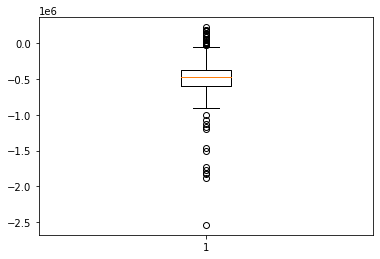

In [11]:
y = list(df.ecg)
plt.boxplot(y)

In [18]:
#calculando a covariancia entre variaveis
covariance = np.cov([df.ecg, df.heartbeat, df.lux])
print(covariance)

[[ 1.86115951e+10 -7.65764771e+05 -2.07042678e+05]
 [-7.65764771e+05  2.39135936e+02  2.25644113e+01]
 [-2.07042678e+05  2.25644113e+01  1.37982549e+01]]


In [36]:
#normalizando a covariancia para que se torne interpretavel(correlacao de pearson)
#metodo mais apropriado para distrubuicoes gaussianas
items = [df.ecg, df.heartbeat, df.lux]
for pair in itertools.combinations(items, 2):
    pCorr, _ = pearsonr(*pair)
    print(f"A correlacao de Pearson entre {pair[0].name} e {pair[1].name} eh: {pCorr:.3f}")

A correlacao de Pearson entre ecg e heartbeat eh: -0.363
A correlacao de Pearson entre ecg e lux eh: -0.409
A correlacao de Pearson entre heartbeat e lux eh: 0.393


In [37]:
#interpretando a covariancia pela correlacao de spearman (para distribuicoes nao gaussianas)
items = [df.ecg, df.heartbeat, df.lux]
for pair in itertools.combinations(items, 2):
    sCorr, _ = spearmanr(*pair)
    print(f"A correlacao de Spearman entre {pair[0].name} e {pair[1].name} eh: {sCorr:.3f}")

A correlacao de Spearman entre ecg e heartbeat eh: -0.343
A correlacao de Spearman entre ecg e lux eh: -0.508
A correlacao de Spearman entre heartbeat e lux eh: 0.479
